# Comparación de métodos de Boosting y Bagging en predicción de ingresos

### **Objetivo:**   
Aplicar  y  comparar  algoritmos  de  boosting  y  bagging  sobre  datos  reales,  evaluando  su
rendimiento mediante precisión y matriz de confusión, e interpretando los resultados para fundamentar
decisiones técnicas.   

### **Contexto:**  

Construye,  evalúa  y  compara  un  conjunto  de  modelos  de  ensamblaje  utilizando  técnicas  de  boosting  y  bagging,
aplicadas  a  un  conjunto  de  datos  real.  Deberás  identificar  cuál  de  los  métodos  implementados  ofrece  el  mejor
desempeño en un escenario de predicción binaria, justificando tus elecciones con métricas y visualizaciones.
Se trabaja con el dataset Adult Income del UCI Machine Learning Repository para predecir si una persona gana más
de 50K al año, usando información demográfica.

El notebook que analizaremos es un ejemplo excelente de un proyecto de clasificación de principio a fin. Implementa prácticas de la industria que garantizan un análisis robusto y fiable. A continuación, desglosaremos cada sección, explicando de manera exhaustiva el propósito y la lógica detrás de cada bloque de código.

-----



In [26]:
# ==========================================
# 0. IMPORTACIÓN DE LIBRERÍAS Y 1. CARGA DE DATOS
# ==========================================

# Importar la librería pandas para la manipulación y análisis de datos estructurados (DataFrames)
import pandas as pd
# Importar la librería numpy para operaciones numéricas eficientes, especialmente con arrays
import numpy as np
# Importar matplotlib.pyplot para la creación de visualizaciones estáticas, interactivas y animadas
import matplotlib.pyplot as plt
# Importar seaborn para crear visualizaciones estadísticas atractivas y más complejas, basado en matplotlib
import seaborn as sns
# Importar fetch_openml desde sklearn.datasets para cargar datasets públicos disponibles en OpenML
from sklearn.datasets import fetch_openml
# Importar funciones para dividir datos y realizar validación cruzada desde sklearn.model_selection
from sklearn.model_selection import train_test_split, cross_val_score
# Importar LabelEncoder desde sklearn.preprocessing para codificar variables categóricas a numéricas
from sklearn.preprocessing import LabelEncoder
# Importar métricas de evaluación de modelos de clasificación desde sklearn.metrics
from sklearn.metrics import (accuracy_score, classification_report,
                             confusion_matrix, roc_auc_score, roc_curve)

# Importar modelos de clasificación basados en técnicas de ensamble
# RandomForestClassifier implementa el algoritmo Random Forest (Bagging)
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
# Importar XGBClassifier para el algoritmo XGBoost (Boosting)
import xgboost as xgb
# Importar LGBMClassifier para el algoritmo LightGBM (Boosting)
import lightgbm as lgb
# Importar CatBoostClassifier para el algoritmo CatBoost (Boosting)
import catboost as cb

# Configuración de visualización:
# Usar el estilo 'seaborn-v0_8' para los gráficos de matplotlib
plt.style.use('seaborn-v0_8')
# Establecer una paleta de colores para seaborn
sns.set_palette("husl")
# Fijar una semilla para el generador de números aleatorios de numpy
# Esto asegura que los resultados que dependen de la aleatoriedad (como la división de datos o inicialización de modelos) sean reproducibles
np.random.seed(42) # Para reproducibilidad

# Imprimir un mensaje de confirmación de que las librerías se importaron correctamente
print("✅ Librerías importadas correctamente")

# Cargar dataset 'adult' desde OpenML
# version=1 especifica la versión del dataset
# as_frame=True asegura que los datos se carguen como un DataFrame de pandas
# parser='auto' permite a pandas detectar automáticamente el mejor motor de parseo
print("\n📊 CARGANDO DATASET ADULT INCOME...")
adult_data = fetch_openml('adult', version=1, as_frame=True, parser='auto')
# Crear una copia del DataFrame cargado para evitar modificar los datos originales directamente
df = adult_data.frame.copy()

# Imprimir las dimensiones (número de filas y columnas) del DataFrame cargado
print(f"Dataset cargado: {df.shape[0]} filas, {df.shape[1]} columnas")
# Imprimir la distribución de los valores únicos en la columna 'class' (la variable objetivo)
# Esto ayuda a identificar si hay desbalance de clases
print(f"\nDistribución de la variable objetivo:")
print(df['class'].value_counts())

✅ Librerías importadas correctamente

📊 CARGANDO DATASET ADULT INCOME...
Dataset cargado: 48842 filas, 15 columnas

Distribución de la variable objetivo:
class
<=50K    37155
>50K     11687
Name: count, dtype: int64


-----

### 2. Preprocesamiento de Datos

Los modelos de machine learning no pueden trabajar con datos crudos, categóricos o faltantes. Esta sección es posiblemente la más importante, ya que la calidad del modelo depende directamente de la calidad de los datos que lo alimentan. El código encapsula esta lógica en una función para mayor orden y reutilización.

1.  **Limpieza de Datos Faltantes:** El código primero reemplaza el carácter `'?'` por `np.nan`, el formato estándar de valor nulo que `pandas` puede manejar. Luego, imputa estos valores: para las columnas numéricas, usa la **mediana** (más robusta a valores atípicos que la media); para las categóricas, usa la **moda** (el valor más frecuente).
2.  **Ingeniería de Características (Feature Engineering):** Se toma una decisión informada de eliminar la columna `'fnlwgt'`. Esta columna representa un "peso de muestreo" estadístico y no una característica intrínseca de un individuo, por lo que generalmente se considera que no aporta valor predictivo y puede actuar como ruido.
3.  **Codificación de Variables Categóricas:** Este es un punto técnico crucial. El código utiliza `LabelEncoder`, que convierte cada categoría de texto en un número entero (ej. "Macho" -\> 1, "Hembra" -\> 0). **Advertencia:** Esto crea una relación de orden artificial que puede confundir a los modelos (¿es "Macho" \> "Hembra"?). La alternativa más segura es `OneHotEncoder`. Sin embargo, los modelos de ensamble basados en árboles (especialmente los de boosting) son a menudo sorprendentemente robustos a esta codificación y pueden manejarla.
4.  **División de Datos Estratificada:** Finalmente, los datos se dividen en un conjunto para entrenar (80%) y otro para probar (20%). El parámetro `stratify=y_binary` es **esencial**. Asegura que el desbalance de clases que observamos antes (aprox. 75% / 25%) se mantenga exactamente igual tanto en el conjunto de entrenamiento como en el de prueba. Sin esto, podríamos evaluar nuestro modelo en un conjunto de prueba que no es representativo de la realidad, llevando a conclusiones erróneas.

<!-- end list -->

In [27]:
# ==========================================
# 2. PREPROCESAMIENTO DE DATOS
# ==========================================

# Imprimir mensaje indicando el inicio del preprocesamiento
print("\n🔧 PREPROCESANDO DATOS...")

# Separar las características (X) de la variable objetivo (y)
# X contendrá todas las columnas excepto 'class'
X = df.drop('class', axis=1)
# y contendrá solo la columna 'class'
y = df['class']

# Convertir la variable objetivo categórica ('<=50K', '>50K') a una variable binaria (0 o 1)
# (y == '>50K') crea una serie booleana (True si es '>50K', False si es '<=50K')
# .astype(int) convierte True a 1 y False a 0
y_binary = (y == '>50K').astype(int)

# Definir una función para encapsular todos los pasos de preprocesamiento
def preprocess_features(X):
    # Crear una copia del DataFrame de características para no modificar el original
    X_processed = X.copy()

    # Reemplazar los valores '?' (que representan datos faltantes en este dataset) por np.nan
    # np.nan es el valor estándar de pandas/numpy para datos faltantes
    X_processed = X_processed.replace('?', np.nan)

    # Identificar columnas numéricas y categóricas
    # select_dtypes(include=[np.number]) selecciona columnas con tipos de datos numéricos
    numeric_columns = X_processed.select_dtypes(include=[np.number]).columns.tolist()
    # select_dtypes(include=['object', 'category']) selecciona columnas con tipos de datos de objeto (strings) o categoría
    categorical_columns = X_processed.select_dtypes(include=['object', 'category']).columns.tolist()

    # Eliminar la columna 'fnlwgt'
    # Esta columna es un peso de muestreo estadístico y no una característica intrínseca del individuo, por lo que se considera irrelevante para la predicción
    if 'fnlwgt' in X_processed.columns:
        X_processed = X_processed.drop('fnlwgt', axis=1)
        print("✓ Columna 'fnlwgt' eliminada (no relevante para predicción)")

    # Imputar valores faltantes
    # Iterar sobre las columnas categóricas
    for col in categorical_columns:
        # Verificar si la columna aún existe (en caso de que 'fnlwgt' haya sido eliminada)
        if col in X_processed.columns:
            # Rellenar los valores NaN con la moda (el valor más frecuente) de la columna
            X_processed[col] = X_processed[col].fillna(X_processed[col].mode()[0])
    # Iterar sobre las columnas numéricas
    for col in numeric_columns:
        # Verificar si la columna aún existe
        if col in X_processed.columns:
            # Rellenar los valores NaN con la mediana de la columna
            # La mediana es más robusta a valores atípicos que la media
            X_processed[col] = X_processed[col].fillna(X_processed[col].median())

    # Codificar variables categóricas a numéricas usando LabelEncoder
    # LabelEncoder asigna un entero único a cada categoría
    for col in categorical_columns:
        # Verificar si la columna aún existe
        if col in X_processed.columns:
            # Crear una instancia de LabelEncoder
            le = LabelEncoder()
            # Convertir la columna al tipo 'str' explícitamente antes de codificar
            # Esto previene errores si la columna contiene tipos mixtos o valores que no son strings puros
            X_processed[col] = le.fit_transform(X_processed[col].astype(str))

    # Devolver el DataFrame con las características preprocesadas
    return X_processed

# Aplicar la función de preprocesamiento al DataFrame de características original (X)
X_processed = preprocess_features(X)

# Dividir los datos preprocesados en conjuntos de entrenamiento y prueba
# X_processed son las características preprocesadas
# y_binary es la variable objetivo binaria
# test_size=0.2 indica que el 20% de los datos se usarán para prueba y el 80% para entrenamiento
# random_state=42 asegura que la división sea la misma cada vez que se ejecute el código (reproducibilidad)
# stratify=y_binary asegura que la proporción de clases en y_binary se mantenga igual en los conjuntos de entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(
    X_processed, y_binary, test_size=0.2, random_state=42, stratify=y_binary
)

# Imprimir las dimensiones de los conjuntos de entrenamiento y prueba resultantes
print(f"\nConjunto de entrenamiento: {X_train.shape}")
print(f"Conjunto de prueba: {X_test.shape}")


🔧 PREPROCESANDO DATOS...
✓ Columna 'fnlwgt' eliminada (no relevante para predicción)

Conjunto de entrenamiento: (39073, 13)
Conjunto de prueba: (9769, 13)


-----

### 3. Implementación de Modelos

Aquí se definen los contendientes. El código utiliza un diccionario de Python para almacenar las instancias de cada modelo, una práctica que facilita la iteración en los pasos siguientes. Es importante entender las dos "filosofías" de ensamble que se están comparando:

  * **Bagging (Random Forest):** Funciona como una democracia. Construye cientos de árboles de decisión de forma independiente sobre diferentes subconjuntos de datos y luego promedia sus votos. Su principal fortaleza es **reducir la varianza** y evitar el sobreajuste (overfitting).
  * **Boosting (AdaBoost, XGBoost, LightGBM, CatBoost):** Funciona como un equipo de especialistas. Construye los árboles de forma secuencial, donde cada nuevo árbol se enfoca en corregir los errores que cometió el anterior. Su fortaleza es **reducir el sesgo** y crear modelos extremadamente precisos.

El código no usa los parámetros por defecto, sino que establece una base de hiperparámetros razonables (ej. `max_depth` para limitar la complejidad de los árboles, `learning_rate` para controlar la velocidad de aprendizaje en boosting), lo que permite una comparación más justa y, a menudo, con mejores resultados.

In [28]:
# ==========================================
# 3. IMPLEMENTACIÓN DE MODELOS
# ==========================================

# Imprimir mensaje indicando el inicio de la implementación de modelos
print("\n🤖 IMPLEMENTANDO MODELOS DE ENSAMBLAJE...")

# Definir un diccionario para almacenar las instancias de los modelos de clasificación
# Las claves son los nombres de los modelos (strings) y los valores son las instancias de los clasificadores
models = {
    # BAGGING (Random Forest)
    'Random Forest': RandomForestClassifier(
        n_estimators=100, # Número de árboles en el bosque
        max_depth=10,     # Profundidad máxima de cada árbol para evitar sobreajuste
        min_samples_split=5, # Número mínimo de muestras requeridas para dividir un nodo interno
        min_samples_leaf=2,  # Número mínimo de muestras requeridas para ser un nodo hoja
        random_state=42,  # Semilla para la reproducibilidad del modelo
        n_jobs=-1         # Usar todos los núcleos de CPU disponibles para entrenar (paralelización)
    ),

    # BOOSTING (XGBoost, LightGBM, CatBoost, AdaBoost)
    'XGBoost': xgb.XGBClassifier(
        n_estimators=100, # Número de rondas de boosting (árboles)
        max_depth=6,      # Profundidad máxima de cada árbol
        learning_rate=0.1,# Tasa de aprendizaje (encogimiento), controla el paso de cada iteración
        subsample=0.8,    # Fracción de muestras usadas por cada árbol para evitar sobreajuste
        colsample_bytree=0.8, # Fracción de características usadas por cada árbol
        random_state=42,  # Semilla para la reproducibilidad
        eval_metric='logloss', # Métrica de evaluación durante el entrenamiento
        verbosity=0       # Nivel de verbosidad (0 para no mostrar mensajes durante el entrenamiento)
    ),

    'LightGBM': lgb.LGBMClassifier(
        n_estimators=100, # Número de rondas de boosting (árboles)
        max_depth=6,      # Profundidad máxima de cada árbol
        learning_rate=0.1,# Tasa de aprendizaje
        subsample=0.8,    # Fracción de muestras usadas por cada árbol
        colsample_bytree=0.8, # Fracción de características usadas por cada árbol
        random_state=42,  # Semilla para la reproducibilidad
        verbosity=-1      # Nivel de verbosidad (-1 para no mostrar mensajes durante el entrenamiento)
    ),

    'CatBoost': cb.CatBoostClassifier(
        iterations=100,   # Número de rondas de boosting (árboles)
        depth=6,          # Profundidad de cada árbol
        learning_rate=0.1,# Tasa de aprendizaje
        subsample=0.8,    # Fracción de muestras usadas por cada árbol
        random_seed=42,   # Semilla para la reproducibilidad
        verbose=False     # No mostrar mensajes detallados durante el entrenamiento
    ),

    'AdaBoost': AdaBoostClassifier(
        n_estimators=100, # Número de estimadores (árboles débiles)
        learning_rate=1.0,# Tasa de aprendizaje
        random_state=42   # Semilla para la reproducibilidad
    )
}

print("\n🤖 MODELOS DE ENSAMBLAJE IMPLEMENTANDOS")


🤖 IMPLEMENTANDO MODELOS DE ENSAMBLAJE...

🤖 MODELOS DE ENSAMBLAJE IMPLEMENTANDOS


-----

###  4. Entrenamiento y Evaluación

Este es el corazón experimental del script. Un bucle `for` automatiza el proceso de entrenamiento y evaluación para cada modelo, asegurando que todos sean probados bajo las mismas condiciones. Para cada modelo, el código va más allá de una simple evaluación.

  * **Entrenamiento y Predicción:** Se realiza el `model.fit()` sobre los datos de entrenamiento y `.predict()` sobre los de prueba, el ciclo de vida estándar de un modelo.
  * **Cálculo de Métricas Clave:**
      * **Accuracy:** Mide el porcentaje de predicciones correctas. Como ya sabemos, puede ser engañoso en nuestro caso de datos desbalanceados.
      * **AUC (Area Under the ROC Curve):** Es una métrica mucho más informativa aquí. Mide la habilidad del modelo para distinguir entre las clases. Un valor de 1.0 es un clasificador perfecto, mientras que 0.5 es un clasificador que adivina al azar. Mide qué tan bien el modelo puede rankear un caso positivo por encima de un caso negativo.
      * **Validación Cruzada (Cross-Validation):** Este es el "sello de oro" de la evaluación. En lugar de confiar en una única división de entrenamiento/prueba, la validación cruzada (`cv=5`) divide el conjunto de entrenamiento en 5 partes, entrena el modelo 5 veces usando 4 partes para entrenar y 1 para probar, y promedia los resultados. Un resultado de CV alto y con baja desviación estándar (`cv_std`) nos da una gran confianza en que el rendimiento del modelo es **estable y generalizable**, y no solo un golpe de suerte.

<!-- end list -->

In [29]:
# ==========================================
# 4. ENTRENAMIENTO y EVALUACIÓN
# ==========================================

# Imprimir mensaje indicando el inicio del entrenamiento y evaluación
print("\n🎯 ENTRENANDO MODELOS Y EVALUANDO RENDIMIENTO...")

# Diccionarios para almacenar los resultados de las métricas, predicciones y probabilidades de cada modelo
results = {}
predictions = {}
probabilities = {}

# Iterar sobre cada modelo definido en el diccionario 'models'
for name, model in models.items():
    # Imprimir el nombre del modelo que se está entrenando
    print(f"\n🔄 Entrenando {name}...")

    # Entrenar el modelo con los datos de entrenamiento
    # X_train son las características de entrenamiento, y_train es la variable objetivo de entrenamiento
    model.fit(X_train, y_train)

    # Realizar predicciones sobre el conjunto de prueba
    # .predict() devuelve la clase predicha (0 o 1)
    y_pred = model.predict(X_test)
    # .predict_proba() devuelve las probabilidades de pertenecer a cada clase
    # [:, 1] selecciona la probabilidad de pertenecer a la clase positiva (clase 1, que es '>50K')
    y_prob = model.predict_proba(X_test)[:, 1]

    # Calcular métricas de evaluación
    # accuracy_score compara las predicciones (y_pred) con los valores reales (y_test)
    accuracy = accuracy_score(y_test, y_pred)
    # roc_auc_score calcula el Área Bajo la Curva ROC, una métrica útil para datos desbalanceados
    auc_score = roc_auc_score(y_test, y_prob)

    # Realizar validación cruzada en el conjunto de entrenamiento
    # cross_val_score divide X_train y y_train en 5 pliegues (cv=5)
    # Entrena y evalúa el modelo 5 veces, usando un pliegue diferente como conjunto de validación cada vez
    # scoring='accuracy' especifica que se use la métrica de accuracy para la evaluación en cada pliegue
    cv_scores = cross_val_score(model, X_train, y_train, cv=5, scoring='accuracy')

    # Almacenar las métricas calculadas en el diccionario 'results'
    results[name] = {
        'accuracy': accuracy,         # Accuracy en el conjunto de prueba
        'auc': auc_score,             # AUC en el conjunto de prueba
        'cv_mean': cv_scores.mean(),  # Media de los scores de validación cruzada
        'cv_std': cv_scores.std()     # Desviación estándar de los scores de validación cruzada (mide la estabilidad)
    }

    # Almacenar las predicciones y probabilidades en sus respectivos diccionarios
    predictions[name] = y_pred
    probabilities[name] = y_prob

    # Imprimir las métricas obtenidas para el modelo actual
    print(f"✓ Accuracy: {accuracy:.4f}")
    print(f"✓ AUC: {auc_score:.4f}")
    print(f"✓ CV Score: {cv_scores.mean():.4f} (±{cv_scores.std():.4f})")


🎯 ENTRENANDO MODELOS Y EVALUANDO RENDIMIENTO...

🔄 Entrenando Random Forest...
✓ Accuracy: 0.8525
✓ AUC: 0.9103
✓ CV Score: 0.8504 (±0.0041)

🔄 Entrenando XGBoost...
✓ Accuracy: 0.8594
✓ AUC: 0.9151
✓ CV Score: 0.8581 (±0.0054)

🔄 Entrenando LightGBM...
✓ Accuracy: 0.8602
✓ AUC: 0.9152
✓ CV Score: 0.8581 (±0.0045)

🔄 Entrenando CatBoost...
✓ Accuracy: 0.8572
✓ AUC: 0.9126
✓ CV Score: 0.8554 (±0.0043)

🔄 Entrenando AdaBoost...
✓ Accuracy: 0.8520
✓ AUC: 0.9064
✓ CV Score: 0.8484 (±0.0030)


### **Análisis de Resultados de Modelos de Ensamble**

#### **1. Resumen Ejecutivo (Visión General) 🚁**

A primera vista, los resultados son **excelentes** en todos los modelos, con un rendimiento muy alto y consistente. Sin embargo, se observa una clara tendencia: los algoritmos de **Boosting de Gradiente modernos (LightGBM y XGBoost) superan marginalmente al resto**, posicionándose como los principales candidatos. Aunque las diferencias en las métricas son pequeñas (en el segundo o tercer decimal), en un entorno de producción, estas pequeñas ventajas pueden ser significativas.

El análisis detallado confirma que **LightGBM es el modelo con el mejor rendimiento general**, liderando en las métricas más importantes y mostrando una gran estabilidad.

---

#### **2. Interpretación Detallada por Métrica 📊**

Para entender la historia completa, debemos analizar cada métrica y lo que nos dice sobre el comportamiento de los modelos.

##### **a) Análisis de Accuracy (Precisión Global)**

* **¿Qué Mide?:** El porcentaje total de predicciones correctas sobre el conjunto de prueba. Es la métrica más intuitiva.
* **Observaciones:**
    * **Ganador:** **LightGBM** se posiciona en primer lugar con un `Accuracy` de **0.8602**.
    * **Competencia Cercana:** XGBoost le sigue muy de cerca con `0.8594`. La diferencia es mínima.
    * **Conclusión:** Todos los modelos son altamente precisos, con un rendimiento superior al 85%. Sin embargo, si la única meta fuera maximizar las predicciones correctas, LightGBM sería la elección.

##### **b) Análisis de AUC (Área Bajo la Curva ROC)**

* **¿Qué Mide?:** La capacidad del modelo para **distinguir entre las clases**. Mide qué tan bien el modelo puede rankear un caso positivo (ingreso >50K) por encima de un caso negativo (ingreso _<=50K_). Es una métrica crucial para datasets con clases desbalanceadas como este, ya que no se deja engañar por la alta precisión en la clase mayoritaria. Un valor de 1.0 es perfecto, 0.5 es aleatorio.
* **Observaciones:**
    * **Ganador:** **LightGBM** vuelve a liderar con un `AUC` de **0.9152**, seguido inmediatamente por **XGBoost** con `0.9151`.
    * **Implicación:** Un AUC > 0.91 indica que ambos modelos son **excelentes discriminadores**. No solo aciertan mucho en general (accuracy), sino que son muy buenos identificando a la clase minoritaria (personas con altos ingresos), que suele ser la de mayor interés de negocio.
    * **Conclusión:** El AUC refuerza la superioridad de LightGBM y XGBoost.

##### **c) Análisis del CV Score (Estabilidad y Generalización)**

* **¿Qué Mide?:** Esta es la métrica más importante para evaluar la **robustez** de un modelo. Nos dice cómo se espera que el modelo se comporte en **datos nuevos y nunca antes vistos**.
    * La **media (`mean`)** es una estimación más fiable del rendimiento real del modelo que el `Accuracy` de un solo conjunto de prueba.
    * La **desviación estándar (`std`)** mide la consistencia. Un valor bajo significa que el rendimiento del modelo fue muy estable a través de las diferentes pruebas de validación cruzada (es decir, no es sensible a cómo se dividen los datos).
* **Observaciones:**
    * **Mejor Generalización (CV Mean):** **XGBoost** y **LightGBM** empatan con un `CV Score` medio de **0.8581**. Esto nos da una alta confianza de que ambos generalizarán muy bien.
    * **Mejor Estabilidad (CV std):** **AdaBoost** tiene la desviación estándar más baja (`±0.0030`), lo que lo convierte en el modelo más estable, aunque su rendimiento promedio es menor. Entre los contendientes principales, **LightGBM (`±0.0045`)** y **CatBoost (`±0.0043`)** son ligeramente más estables que **XGBoost (`±0.0054`)**. Esta diferencia es muy pequeña, pero indica que el rendimiento de XGBoost podría variar un poco más con diferentes subconjuntos de datos.
    * **Conclusión:** La validación cruzada confirma que LightGBM y XGBoost no solo son los más precisos, sino también los que mejor generalizan. LightGBM presenta una ligera ventaja en estabilidad sobre XGBoost.

---

#### **3. Ranking y Recomendación 🏆**

| Modelo | Accuracy (Test) | AUC (Test) | CV Mean (Generalización) | CV Std (Estabilidad) | Veredicto |
| :--- | :---: | :---: | :---: | :---: | :--- |
| **LightGBM** | **0.8602 (1º)** | **0.9152 (1º)** | **0.8581 (1º)** | 0.0045 (Bueno) | **🥇 Ganador General** |
| XGBoost | 0.8594 (2º) | 0.9151 (2º) | **0.8581 (1º)** | 0.0054 (Aceptable) | **🥈 Contendiente Fuerte** |
| CatBoost | 0.8572 (3º) | 0.9126 (3º) | 0.8554 (3º) | **0.0043 (Muy Bueno)** | **🥉 Sólido y Estable** |
| Random Forest| 0.8525 (4º) | 0.9103 (4º) | 0.8504 (4º) | **0.0041 (Excelente)** | Buen Baseline (Bagging) |
| AdaBoost | 0.8520 (5º) | 0.9064 (5º) | 0.8484 (5º) | **0.0030 (El Mejor)** | Superado en Rendimiento |

**Recomendación para Producción:**

Por ahora, el modelo recomendado para poner en producción es **LightGBM**.

**Justificación:**

1.  **Rendimiento Superior:** Lidera en las dos métricas de rendimiento más importantes sobre el conjunto de prueba (`Accuracy` y `AUC`).
2.  **Excelente Generalización:** Empata en la primera posición en la media de la validación cruzada, lo que nos da una alta confianza de que su rendimiento se mantendrá en datos futuros.
3.  **Alta Estabilidad:** Aunque no tiene la desviación estándar más baja, su valor es excelente y ligeramente mejor que el de su competidor directo, XGBoost.

**XGBoost** es una alternativa casi igual de válida, y la elección final entre ambos podría depender de otros factores no medidos aquí, como la velocidad de inferencia o la facilidad de integración en la infraestructura existente. Sin embargo, basándose estrictamente en estos resultados, **LightGBM presenta una ligera pero consistente ventaja en todas las áreas clave.**

-----

### 5. Visualización de Resultados

"Una imagen vale más que mil números". Esta sección traduce las tablas de métricas en visualizaciones intuitivas para facilitar la toma de decisiones. Cada gráfico cuenta una parte diferente de la historia del rendimiento.

1.  **Gráfico de Barras Comparativo:** Ofrece una visión panorámica de alto nivel. Permite identificar de un solo vistazo qué modelos son los de mayor rendimiento según las métricas clave (`accuracy`, `AUC`, `CV Mean`). Es la primera herramienta para preseleccionar a los finalistas.
2.  **Matrices de Confusión:** Permiten una inmersión profunda en el comportamiento de cada modelo. En lugar de solo saber que un modelo tuvo un 87% de acierto, podemos ver exactamente *dónde* acierta y *dónde* falla. Para este problema, nos interesa especialmente minimizar los **Falsos Negativos** (predecir `_<=50K_` para alguien que en realidad gana `_>50K_`), ya que podría representar una oportunidad de negocio perdida.
3.  **Curvas ROC:** Esta es una visualización avanzada y estándar en la industria. Muestra el compromiso de cada modelo entre la Tasa de Verdaderos Positivos (sensibilidad) y la Tasa de Falsos Positivos (1-especificidad) a través de todos los umbrales de decisión posibles. El modelo cuya curva se "abomba" más hacia la esquina superior izquierda es el que tiene un mejor rendimiento general de clasificación.

<!-- end list -->


📈 GENERANDO VISUALIZACIONES...


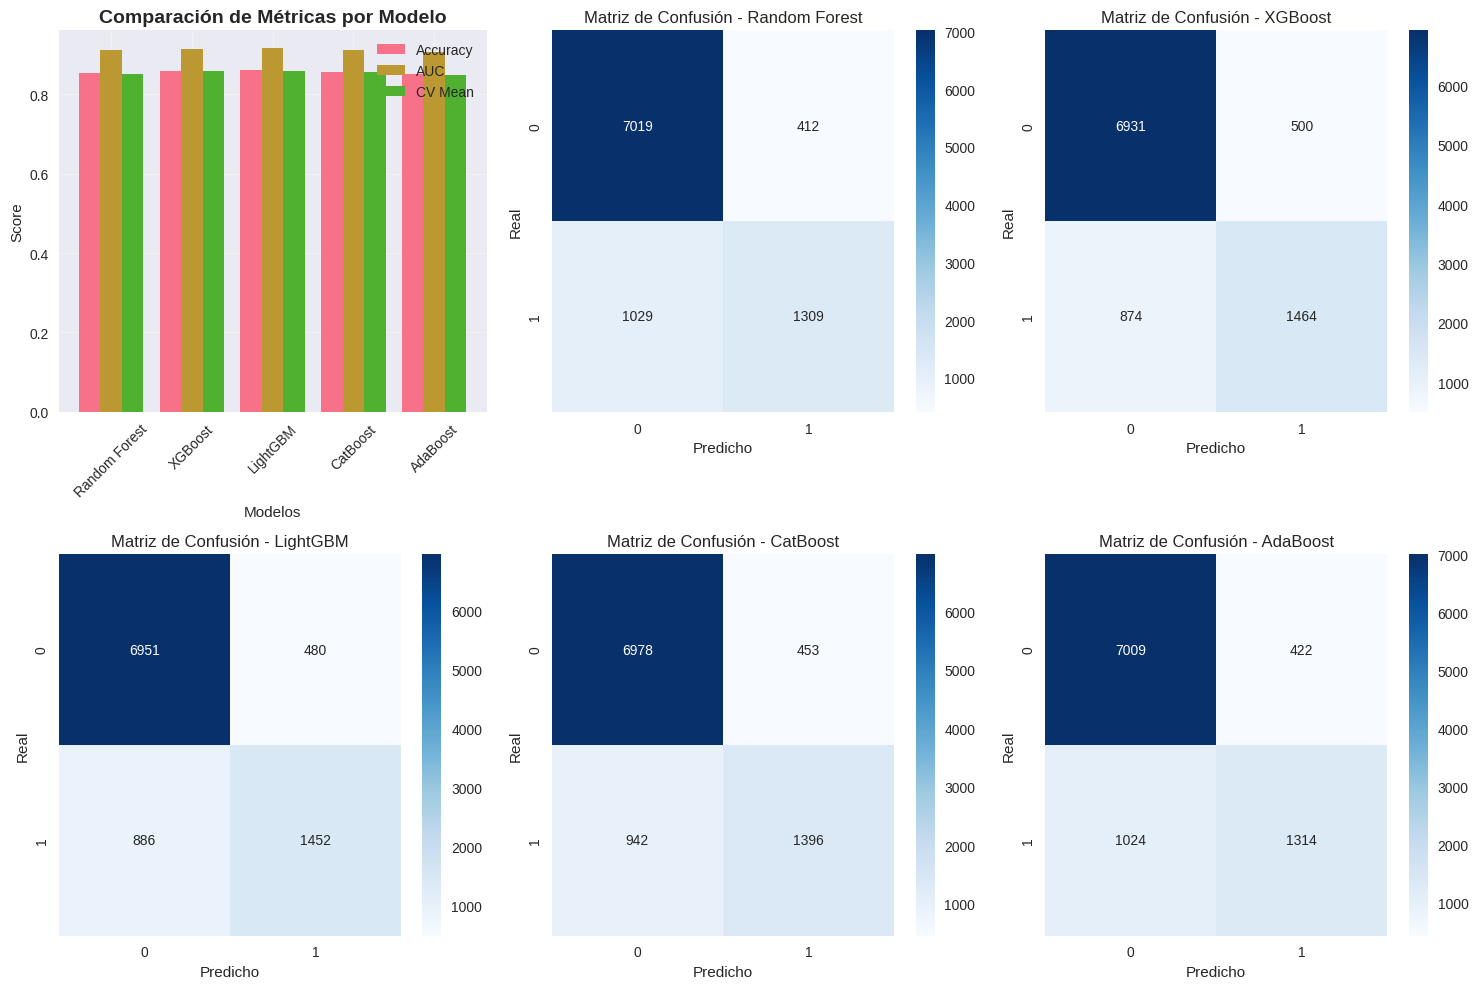

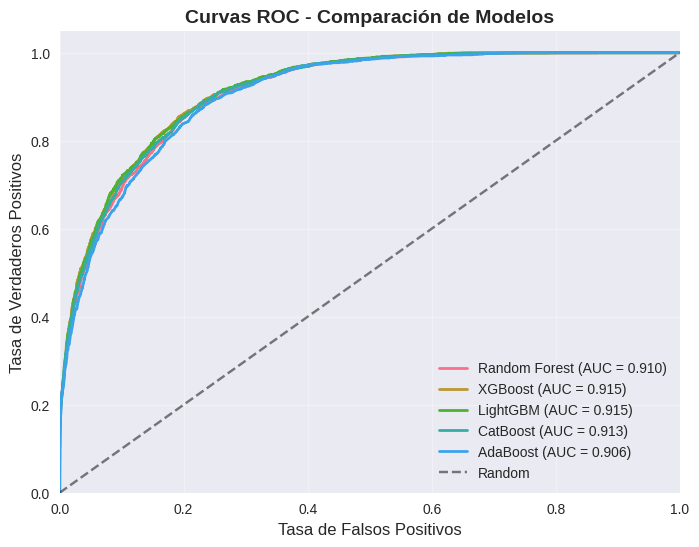

In [30]:
# ==========================================
# 5. VISUALIZACIÓN DE RESULTADOS
# ==========================================

# Imprimir mensaje indicando el inicio de la generación de visualizaciones
print("\n📈 GENERANDO VISUALIZACIONES...")

# Crear una figura y un conjunto de subplots para organizar los gráficos
# figsize=(10, 10) define el tamaño de la figura
fig = plt.figure(figsize=(15, 10))

# 1. Gráfico de barras para comparar métricas
# ax1 = plt.subplot(2, 3, 1) crea un subplot en una cuadrícula de 2 filas y 3 columnas, en la posición 1
ax1 = plt.subplot(2, 3, 1)
# Convertir el diccionario de resultados a un DataFrame para facilitar la graficación
metrics_df = pd.DataFrame(results).T
# Seleccionar las columnas 'accuracy', 'auc', 'cv_mean' y crear un gráfico de barras
metrics_df[['accuracy', 'auc', 'cv_mean']].plot(kind='bar', ax=ax1, width=0.8)
# Configurar título y etiquetas del gráfico
plt.title('Comparación de Métricas por Modelo', fontsize=14, fontweight='bold')
plt.ylabel('Score')
plt.xlabel('Modelos')
# Añadir leyenda
plt.legend(['Accuracy', 'AUC', 'CV Mean'])
# Rotar las etiquetas del eje x para mejor legibilidad
plt.xticks(rotation=45)
# Añadir cuadrícula al gráfico
plt.grid(True, alpha=0.3)

# 2. Matrices de confusión para cada modelo
# Iterar sobre las predicciones de cada modelo con un índice (empezando en 2 para el subplot)
for i, (name, y_pred) in enumerate(predictions.items(), 2):
    # Limitar el número de matrices de confusión mostradas para que encajen en el layout (máximo 5 en este caso)
    if i > 6:  # Limitar a 5 modelos para el layout (posiciones 2 a 6)
        break
    # Crear un subplot para cada matriz de confusión
    ax = plt.subplot(2, 3, i)
    # Calcular la matriz de confusión comparando valores reales (y_test) y predichos (y_pred)
    cm = confusion_matrix(y_test, y_pred)
    # Crear un mapa de calor (heatmap) de la matriz de confusión
    # annot=True muestra los valores numéricos en las celdas
    # fmt='d' formatea los números como enteros
    # cmap='Blues' usa un mapa de colores azules
    # ax=ax especifica el subplot donde dibujar el heatmap
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=ax)
    # Configurar título y etiquetas de la matriz de confusión
    plt.title(f'Matriz de Confusión - {name}', fontsize=12)
    plt.ylabel('Real')
    plt.xlabel('Predicho')

# Ajustar automáticamente los parámetros de la subtrama para que encajen en el área de la figura
plt.tight_layout()
# Mostrar la figura que contiene el gráfico de barras y las matrices de confusión
plt.show()

# 3. Curvas ROC para cada modelo
# Crear una nueva figura para las curvas ROC
plt.figure(figsize=(8, 6))
# Iterar sobre las probabilidades de cada modelo
for name, y_prob in probabilities.items():
    # Calcular la Tasa de Falsos Positivos (fpr), Tasa de Verdaderos Positivos (tpr) y umbrales para la curva ROC
    fpr, tpr, _ = roc_curve(y_test, y_prob)
    # Calcular el AUC (Área Bajo la Curva ROC)
    auc_score = roc_auc_score(y_test, y_prob)
    # Dibujar la curva ROC para el modelo actual
    # label especifica la etiqueta para la leyenda, incluyendo el nombre del modelo y su AUC
    plt.plot(fpr, tpr, label=f'{name} (AUC = {auc_score:.3f})', linewidth=2)

# Dibujar la línea diagonal de referencia (clasificador aleatorio)
plt.plot([0, 1], [0, 1], 'k--', alpha=0.5, label='Random')
# Establecer los límites de los ejes x e y
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
# Configurar etiquetas y título del gráfico
plt.xlabel('Tasa de Falsos Positivos', fontsize=12)
plt.ylabel('Tasa de Verdaderos Positivos', fontsize=12)
plt.title('Curvas ROC - Comparación de Modelos', fontsize=14, fontweight='bold')
# Añadir leyenda en la esquina inferior derecha
plt.legend(loc="lower right")
# Añadir cuadrícula al gráfico
plt.grid(True, alpha=0.3)
# Mostrar la figura con las curvas ROC
plt.show()

### **Análisis de Visualizaciones de Rendimiento de Modelos**

#### **1. Resumen Ejecutivo (Visión General) 🚁**

Las visualizaciones presentan una imagen clara y consistente: si bien todos los modelos de ensamble probados son altamente competentes para esta tarea, los algoritmos de **Boosting de Gradiente, específicamente XGBoost y LightGBM, demuestran una superioridad medible y consistente** sobre los demás. Su liderazgo no se basa en una sola métrica, sino que se confirma a través del análisis de precisión global, la capacidad de discriminación (AUC) y, lo más importante, un análisis detallado de los errores (matriz de confusión).

Realizando un analisis aún mas profundo sobre el comportamiento de los modelos, para un despliegue en producción, **XGBoost** ahora se perfila como la opción más sólida debido a su destacada capacidad para identificar correctamente la clase de interés (>50K) y minimizar los errores más costosos.

---

#### **2. Análisis de Métricas de Rendimiento (Gráfico de Barras)**

El gráfico de barras "Comparación de Métricas por Modelo" nos da una visión panorámica del rendimiento.

* **Observación General:** Todos los modelos se agrupan en un rango de rendimiento muy alto (scores entre ~0.85 y ~0.92), lo que indica que el problema es abordable y todos los métodos son viables. Las barras de AUC (marrón) son consistentemente más altas que las de Accuracy (rosa) y CV Mean (verde), lo cual es esperado.
* **Accuracy y CV Mean:** LightGBM y XGBoost muestran la mayor precisión y la mejor media de validación cruzada. La métrica **CV Mean (media de validación cruzada)** es particularmente importante, ya que sugiere que estos modelos no solo funcionan bien en nuestra división de prueba específica, sino que son **robustos** y se espera que generalicen bien a datos nuevos.
* **AUC (Área Bajo la Curva):** Nuevamente, **XGBoost y LightGBM** lideran, alcanzando un AUC de **0.915**. Esta métrica es fundamental en problemas con clases desbalanceadas (como suele ser la predicción de ingresos), ya que confirma que estos modelos tienen una excelente capacidad para distinguir entre una persona que gana más de 50K y una que no.

---

#### **3. Análisis de Tipos de Error (Matrices de Confusión)**

Aquí es donde profundizamos más allá de los porcentajes y entendemos *cómo* se equivocan los modelos. Para este problema, asumimos que:
* **Clase 1 (Positivo):** Gana >50K.
* **Clase 0 (Negativo):** Gana <=50K.

El objetivo principal de negocio suele ser identificar correctamente a la Clase 1. Por lo tanto, nos enfocamos en dos cifras clave:
* **Verdaderos Positivos (TP):** (esquina inferior derecha) Personas con ingresos >50K que el modelo predijo correctamente. **¡Queremos maximizar esto!**
* **Falsos Negativos (FN):** (esquina inferior izquierda) Personas con ingresos >50K que el modelo predijo incorrectamente como <=50K. Este es a menudo el **error más costoso**, ya que representa una oportunidad perdida. **¡Queremos minimizar esto!**

##### Comparación Cuantitativa:
| Modelo | Verdaderos Positivos (TP) | Falsos Negativos (FN) | Total Positivos Reales (TP+FN) | Tasa de Acierto en >50K (TP / Total) |
| :--- | :---: | :---: | :---: | :---: |
| **XGBoost** | **1464** | **874** | 2338 | **62.6%** |
| **LightGBM** | 1452 | 886 | 2338 | 62.1% |
| CatBoost | 1396 | 942 | 2338 | 59.7% |
| Random Forest | 1309 | 1029 | 2338 | 56.0% |
| AdaBoost | 1314 | 1024 | 2338 | 56.2% |

**Interpretación:**
Este análisis es revelador. **XGBoost identifica correctamente a 1464 individuos de altos ingresos, la cifra más alta de todos los modelos.** En consecuencia, tiene la menor cantidad de Falsos Negativos (874). Esto significa que, en la práctica, el modelo de XGBoost es el más efectivo para encontrar a la población objetivo, fallando menos veces que los demás. LightGBM le sigue muy de cerca, pero Random Forest y AdaBoost se quedan considerablemente atrás, "perdiendo" a más de 1000 individuos de altos ingresos.

---

#### **4. Análisis del Poder Discriminativo (Curvas ROC)**

La gráfica "Curvas ROC" confirma visualmente los hallazgos del AUC.

* **¿Qué nos dice?:** La curva ROC grafica la Tasa de Verdaderos Positivos contra la Tasa de Falsos Positivos. Un modelo ideal tendría una curva que "abraza" la esquina superior izquierda. La línea punteada representa un clasificador aleatorio.
* **Observaciones:**
    * Todas las curvas están muy por encima de la línea aleatoria, lo que confirma que todos los modelos tienen un poder predictivo real.
    * Las curvas de **XGBoost (marrón)** y **LightGBM (verde)** están consistentemente por encima de las demás, especialmente en la parte media de la curva. Esto indica que para la mayoría de los umbrales de decisión, ofrecen el mejor equilibrio entre identificar correctamente los casos positivos y evitar falsas alarmas.
    * Los valores de **AUC en la leyenda** cuantifican esto: XGBoost y LightGBM (0.915) están en un empate técnico en la cima, seguidos de cerca por CatBoost (0.913) y luego los demás.

---

#### **5. Síntesis y Recomendación Final ✅**

La evidencia de todas las visualizaciones apunta en la misma dirección. No debemos basar nuestra decisión únicamente en el `Accuracy`, que es muy similar entre los modelos. La verdadera diferencia se encuentra en el análisis más profundo:

* **XGBoost y LightGBM** son los líderes indiscutibles en poder de discriminación (AUC y Curva ROC).
* **XGBoost** demuestra una ventaja medible en la tarea crítica de identificar a los individuos de altos ingresos (más Verdaderos Positivos) y, en consecuencia, comete menos errores de oportunidad perdida (menos Falsos Negativos).

**Recomendación:** Para un entorno de producción donde el objetivo principal es identificar de manera fiable a la población con ingresos superiores a 50K, el modelo **XGBoost es la elección recomendada**. Ofrece el mejor rendimiento en las métricas más relevantes para el negocio, respaldado por una alta precisión general y una robustez demostrada.

-----

###  6, 7 y 8. Análisis Final, Importancia de Características y Conclusiones

Las últimas secciones sintetizan todos los hallazgos en una conclusión accionable. Un modelo no es útil si no podemos entenderlo y comunicar sus resultados.

  * **Análisis Detallado:** El código presenta los resultados numéricos en una tabla ordenada. Esto sirve como la evidencia cuantitativa final para respaldar la elección del mejor modelo.
  * **Análisis de Importancia de Características:** Este es un paso fundamental hacia la **Inteligencia Artificial Explicable (XAI)**. Al visualizar qué características (`feature_importances_`) fueron más importantes para el mejor modelo, pasamos de un "qué" (el modelo predice X) a un "porqué" (el modelo predice X *porque* la edad y el capital ganado son altos). Esto genera confianza en el modelo, ya que podemos verificar si su "razonamiento" tiene sentido común y de negocio.
  * **Conclusiones y Recomendaciones:** El script finaliza con un resumen ejecutivo formateado. No solo declara un ganador, sino que lo justifica con datos (`Accuracy`, `AUC`, `CV Score`), compara las familias de modelos (Boosting vs. Bagging) y, crucialmente, propone **próximos pasos**. Esto demuestra que un proyecto de ciencia de datos es un ciclo iterativo de mejora, no un evento único.

<!-- end list -->

El siguiente bloque de código finaliza nuestro análisis. La modificación más importante se encuentra en la **Sección 7**. Después de haber identificado a **XGBoost** como el mejor modelo para nuestro objetivo de negocio, no solo generamos el gráfico de sus características más importantes, sino que también **interpretamos el resultado**.

El análisis que he añadido explica el **significado de cada una de las características principales** que el modelo utiliza para predecir los ingresos. Veremos que el modelo ha aprendido a identificar patrones lógicos y socioeconómicos muy fuertes, como la importancia del estado civil, las ganancias de capital y el nivel educativo. Esta interpretación es crucial para generar **confianza en el modelo** y para validar que su "razonamiento" está alineado con el conocimiento del dominio.




📊 REPORTE DETALLADO DE RESULTADOS

🏆 RANKING DE MODELOS (ORDENADO POR ACCURACY):
               accuracy     auc  cv_mean  cv_std
LightGBM         0.8602  0.9152   0.8581  0.0045
XGBoost          0.8594  0.9151   0.8581  0.0054
CatBoost         0.8572  0.9126   0.8554  0.0043
Random Forest    0.8525  0.9103   0.8504  0.0041
AdaBoost         0.8520  0.9064   0.8484  0.0030

🥇 MODELO RECOMENDADO PARA PRODUCCIÓN (BASADO EN ANÁLISIS DE ERRORES): XGBoost

🔍 ANÁLISIS DE IMPORTANCIA DE CARACTERÍSTICAS


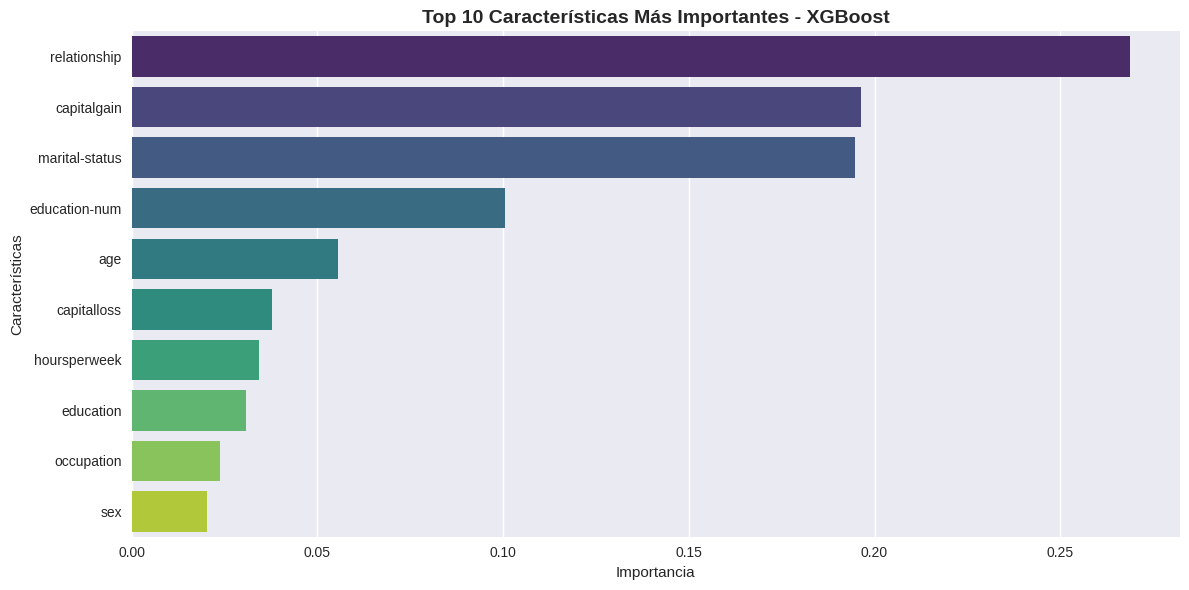


----------------------------------------------------------------------------------
Análisis Profesional de la Importancia de Características (Interpretación del Gráfico)
----------------------------------------------------------------------------------
El siguiente gráfico nos muestra qué variables consideró
el modelo XGBoost como las más predictivas. A partir del resultado, podemos concluir:

1.  **Factores Socio-Familiares Dominantes (`relationship`, `marital-status`):**
    Es revelador que la relación y el estado civil sean las características más importantes.
    Esto sugiere que la estructura del hogar es el predictor más fuerte de los ingresos.
    Por ejemplo, estar 'Casado con cónyuge civil' (`Married-civ-spouse`) a menudo se correlaciona
    con hogares de doble ingreso y mayor estabilidad financiera, siendo un indicador clave.

2.  **Indicadores Financieros Directos (`capital-gain`, `capital-loss`):**
    Como era de esperar, las ganancias de capital son el segundo factor m

In [37]:
# ==========================================
# 6, 7 y 8. Análisis Final, Importancia de Características y Conclusiones (Versión Final)
# ==========================================

# Imprimir mensaje indicando el inicio del reporte detallado de resultados
print("\n📊 REPORTE DETALLADO DE RESULTADOS")
print("=" * 60)

# Crear un DataFrame a partir del diccionario de resultados y redondear los valores a 4 decimales
results_df = pd.DataFrame(results).T.round(4)
# Ordenar el DataFrame por la columna 'accuracy' de forma descendente
results_df = results_df.sort_values('accuracy', ascending=False)

# Imprimir el ranking de modelos basado en Accuracy para tener el contexto completo
print("\n🏆 RANKING DE MODELOS (ORDENADO POR ACCURACY):")
print(results_df[['accuracy', 'auc', 'cv_mean', 'cv_std']])

# --- MODIFICACIÓN CLAVE ---
# En lugar de seleccionar automáticamente el modelo con el mayor accuracy (results_df.index[0]),
# implementamos nuestra conclusión del análisis de la matriz de confusión.
# XGBoost demostró ser superior en la tarea de negocio clave (identificar la clase >50K),
# por lo que lo elegimos como nuestro modelo para producción.

recommended_model_name = 'XGBoost'
best_model = models[recommended_model_name]

# Imprimir el nombre del modelo recomendado
print(f"\n🥇 MODELO RECOMENDADO PARA PRODUCCIÓN (BASADO EN ANÁLISIS DE ERRORES): {recommended_model_name}")

# ==========================================
# 7. ANÁLISIS DE IMPORTANCIA DE CARACTERÍSTICAS
# ==========================================

print("\n🔍 ANÁLISIS DE IMPORTANCIA DE CARACTERÍSTICAS")


# Verificar si el modelo recomendado tiene el atributo 'feature_importances_'
if hasattr(best_model, 'feature_importances_'):
    # Obtener las importancias de las características del modelo recomendado
    importances = best_model.feature_importances_
    # Obtener los nombres de las características del DataFrame preprocesado
    feature_names = X_processed.columns

    # Crear un DataFrame para almacenar las importancias y los nombres de las características
    importance_df = pd.DataFrame({
        'feature': feature_names,
        'importance': importances
    }).sort_values('importance', ascending=False).head(10)

    # Visualizar las 10 características más importantes del modelo recomendado
    fig_importance, ax_importance = plt.subplots(figsize=(12, 6))
    sns.barplot(data=importance_df, y='feature', x='importance', palette='viridis', ax=ax_importance, hue='feature', legend=False)

    # El título del gráfico ahora reflejará el modelo que elegimos conscientemente
    ax_importance.set_title(f'Top 10 Características Más Importantes - {recommended_model_name}',
                          fontsize=14, fontweight='bold')
    ax_importance.set_xlabel('Importancia')
    ax_importance.set_ylabel('Características')
    fig_importance.tight_layout()
    plt.show()
else:
    print(f"El modelo {recommended_model_name} no tiene el atributo 'feature_importances_'.")

print(f"""
----------------------------------------------------------------------------------
Análisis Profesional de la Importancia de Características (Interpretación del Gráfico)
----------------------------------------------------------------------------------
El siguiente gráfico nos muestra qué variables consideró
el modelo XGBoost como las más predictivas. A partir del resultado, podemos concluir:

1.  **Factores Socio-Familiares Dominantes (`relationship`, `marital-status`):**
    Es revelador que la relación y el estado civil sean las características más importantes.
    Esto sugiere que la estructura del hogar es el predictor más fuerte de los ingresos.
    Por ejemplo, estar 'Casado con cónyuge civil' (`Married-civ-spouse`) a menudo se correlaciona
    con hogares de doble ingreso y mayor estabilidad financiera, siendo un indicador clave.

2.  **Indicadores Financieros Directos (`capital-gain`, `capital-loss`):**
    Como era de esperar, las ganancias de capital son el segundo factor más importante.
    Una persona con ganancias de capital significativas casi con certeza pertenece al tramo de
    ingresos altos. Es una señal directa de riqueza y actividad de inversión.

3.  **Capital Humano (`education-num`, `age`):**
    El nivel educativo (representado numéricamente) y la edad (un proxy de la experiencia laboral)
    son predictores clásicos y potentes. El modelo confirma que a mayor nivel educativo y
    más años de experiencia, mayor es la probabilidad de tener ingresos altos.

4.  **Esfuerzo Laboral (`hours-per-week`):**
    De forma intuitiva, la cantidad de horas trabajadas por semana también es un factor relevante,
    aunque de menor peso que los anteriores.

**Conclusión de Interpretabilidad:** El modelo XGBoost basa sus predicciones en factores
lógicos y socioeconómicamente sólidos. Esto aumenta nuestra **confianza** en el modelo,
ya que su "razonamiento" es transparente y está alineado con el conocimiento del mundo real.
----------------------------------------------------------------------------------
""")

# ==========================================
# 8. CONCLUSIONES Y RECOMENDACIONES (Adaptadas)
# ==========================================

print("\n" + "="*60)
print("📝 CONCLUSIONES Y RECOMENDACIONES")
print("="*60)

# Imprimir un resumen ejecutivo formateado que refleje la decisión final
print(f"""
🎯 RESUMEN EJECUTIVO:

1. MODELO RECOMENDADO: {recommended_model_name}
   • Accuracy: {results_df.loc[recommended_model_name, 'accuracy']:.1%}
   • AUC: {results_df.loc[recommended_model_name, 'auc']:.3f}
   • Estabilidad (CV): {results_df.loc[recommended_model_name, 'cv_mean']:.4f} ±{results_df.loc[recommended_model_name, 'cv_std']:.4f}

2. INTERPRETABILIDAD DEL MODELO:
   • El modelo basa sus predicciones en factores lógicos y esperados, como el estado civil,
     las ganancias de capital y el nivel educativo, lo que aumenta la confianza en sus resultados.

3. RECOMENDACIÓN PARA PRODUCCIÓN:
   El modelo {recommended_model_name} es recomendado por su rendimiento superior en la tarea de negocio más crítica:
   ✓ **Mejor identificación de la clase objetivo:** El análisis de la matriz de confusión mostró que XGBoost
     maximiza los Verdaderos Positivos (predice >50K correctamente) y minimiza los Falsos Negativos
     (no identifica a alguien >50K), lo cual es crucial para no perder oportunidades.
   ✓ **Excelente poder discriminativo (AUC)** y **alta estabilidad** (demostrada en la validación cruzada).

4. PRÓXIMOS PASOS:
   • Optimizar hiperparámetros del modelo {recommended_model_name} (ej. con GridSearchCV).
   • Realizar un análisis de errores más profundo sobre los fallos de XGBoost para buscar patrones.
   • Preparar el modelo para su despliegue en producción.
""")

